In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from math import ceil
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
animation=pd.read_csv("anime/anime.csv",encoding="utf-8")
rank=pd.read_csv("anime/rating.csv",encoding="utf-8")
user=pd.read_csv("anime/user.csv",encoding="utf-8")

In [2]:
##数据与处理：处理anime包含空值的数据
animation_drop=animation
nan_values=animation[animation.isnull().T.any()]
nan_id=nan_values["anime_id"]
animation_drop=animation_drop[~animation_drop['anime_id'].isin(nan_id)]
animation_drop=animation_drop.reset_index()
animation_drop_o=animation_drop.values
animation_drop_o2=animation_drop

In [3]:
##数据预处理：处理rank包含空值的数据
rank_drop1=rank[(rank.rating!=-1)]
rank_drop1=rank_drop1.dropna(axis=0, how='any')
rank_drop1=rank_drop1[~rank_drop1['anime_id'].isin(nan_id)]
rank_drop1=rank_drop1.reset_index()
rank_drop1=rank_drop1.drop("index",axis=1)
rank_drop1_o=rank_drop1.values
rank_drop1_o2=rank_drop1

In [4]:
#确定动漫有多少Genres类(共81种)
anime_class_num=[]
anime_class=animation_drop[["genre"]].values
for anime in anime_class:
    anime=anime.__str__()
    anime=anime.replace("'",'')
    anime=anime.replace("[",'')
    anime=anime.replace(']','')
    anime=anime.split(',')
    for anime_t in anime:
        if anime_t in anime_class_num:
            continue
        else:
            anime_class_num.append(anime_t)
anime_class_num= pd.DataFrame(anime_class_num)
anime_class_num.tail()

,0
78,Hentai
79,Yaoi
80,Hentai
81,Yuri
82,Yaoi


In [5]:
#确定动漫的类型，是何种形式播放，分为TV，OVA，Special，Music，ONA五种
anime_type_num=[]
anime_type=animation_drop[["type"]].values
for anime in anime_type:
    anime=anime.__str__()
    anime=anime.replace("'",'')
    anime=anime.replace("[",'')
    anime=anime.replace(']','')
    if anime in anime_type_num:
        continue
    else:
        anime_type_num.append(anime)
anime_type_num= pd.DataFrame(anime_type_num)
anime_type_num.tail()

,0
1,TV
2,OVA
3,Special
4,Music
5,ONA


In [6]:
#动漫类型转数字字典
genres_set = set()

for val in animation_drop['genre'].str.split(','):
    genres_set.update(val)
print(genres_set)
genres_set.add('<PAD>')

genres2int = {val:ii for ii, val in enumerate(genres_set)}
genres_map = {val:[genres2int[row] for row in val.split(',')] for ii,val in enumerate(set(animation_drop['genre']))}
for key in genres_map:
    for cnt in range(max(genres2int.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
animation_drop['genre'] = animation_drop['genre'].map(genres_map)


{' Shounen Ai', 'Shounen', ' Super Power', 'Comedy', ' Thriller', 'Slice of Life', ' Military', ' Demons', ' Shounen', ' Sci-Fi', ' Police', 'Romance', 'Demons', ' Seinen', 'Seinen', 'Sports', ' School', ' Yaoi', 'Action', 'Vampire', ' Mystery', 'Josei', ' Kids', 'Thriller', ' Harem', 'Space', ' Music', ' Slice of Life', ' Mecha', ' Ecchi', 'Harem', ' Romance', 'Music', 'Samurai', 'Super Power', ' Josei', 'Hentai', ' Hentai', 'Cars', 'Supernatural', ' Yuri', 'Sci-Fi', ' Psychological', 'Psychological', 'Magic', 'Dementia', ' Historical', ' Game', ' Drama', 'Game', ' Samurai', 'Adventure', 'Mystery', 'Drama', ' Shoujo', 'School', ' Horror', 'Historical', ' Supernatural', 'Fantasy', 'Police', 'Martial Arts', 'Ecchi', ' Sports', ' Dementia', ' Space', 'Kids', 'Shoujo', ' Shoujo Ai', ' Comedy', ' Fantasy', 'Parody', ' Adventure', ' Parody', 'Mecha', 'Yaoi', 'Horror', 'Military', ' Vampire', ' Magic', ' Martial Arts', ' Cars'}


In [7]:
 #动漫name转数字字典
name_set = set()
for val in animation_drop['name'].str.split():
    name_set.update(val)
    
name_set.add('<PAD>')
print(name_set)
name2int = {val:ii for ii, val in enumerate(name_set)}

#将动漫name转成等长数字列表，长度是20
name_count = 20
name_map = {val:[name2int[row] for row in val.split()] for ii,val in enumerate(set(animation_drop['name']))}
for key in name_map:
    for cnt in range(name_count - len(name_map[key])):
        name_map[key].insert(len(name_map[key]) + cnt,name2int['<PAD>'])
    
animation_drop['name'] = animation_drop['name'].map(name_map)


{'Mizutori', 'Reload', 'Chinpui:', 'Halley', 'Wingman', '(1985)', 'Kenshin:', 'Revenge', 'Todoita', 'Mikuni', 'Friagne', 'Kewaishi', 'Hasshin', 'Souzetsu', 'Cocotama', 'Footprints', 'Koishiteru:', 'Futarigurashi', 'Iruka!', 'Kako-hen', 'Taishou', 'Raihousha', '(Second)', 'Haikei', 'ni,', 'Misha', 'Kyouakuhan', 'Tamagon', 'Insert', 'ray=out', 'Sabetsu', 'Shuukan', 'Badaui', 'Takayanagi', 'Kurage', 'Kyoukan', 'Furikaeru', 'AIUEO', 'Asari-chan:', 'Violence', 'Okurimono', 'Angels', 'Fubuki', 'Uwasa', 'Lite', 'Onna-tachi', 'Absolute', 'Lolling', 'Harbor', 'Arion', 'Lemon:', 'Koukyougaku', 'Ranpo', 'High-School', 'Hitohira', 'Handa-kun', '(2015):', 'Shinseiki/Zero', 'Zenon', 'Kurokami', 'Bishounen', 'Yuke!', 'Otherwise', 'Falcom', 'Seirou', 'Michiko', 'Saranaru', 'Breakers', 'Jazz', 'Isekai', 'Mizuiro', 'Nagato', 'R&amp;B', 'Z/X:', 'Tenbin', 'Tetsuko', 'Shoukoushi', 'World:', 'Maryuuou', 'Queen', 'Otohime', 'Lost', 'ni!?', 'Requiem', 'Maru', 'Joukyou', 'Bakuman.:', 'Nemure', 'tri.', 'Kigaeta

In [8]:
#动漫类型转数字字典
type_set = set()

for val in animation_drop['type'].str.split():
    type_set.update(val)
print(type_set)
type_set.add('<PAD>')

type2int = {val:ii for ii, val in enumerate(type_set)}
type_map = {val:[type2int[row] for row in val.split()] for ii,val in enumerate(set(animation_drop['type']))}
for key in type_map:
    for cnt in range(max(type2int.values()) - len(type_map[key])):
        type_map[key].insert(len(type_map[key]) + cnt,type2int['<PAD>'])
    
animation_drop['type'] = animation_drop['type'].map(type_map)

{'Special', 'ONA', 'TV', 'Music', 'Movie', 'OVA'}


In [9]:
merge_data = pd.merge(pd.merge(rank_drop1, user), animation_drop,on='anime_id')

In [10]:
merge_data=merge_data[["user_id", "anime_id", "rating_x", "name", "genre", "type"]]

In [11]:
target_fields = ['rating_x']
features_pd, targets_pd = merge_data.drop(target_fields, axis=1), merge_data[target_fields]
features = features_pd.values
targets_values = targets_pd.values

In [12]:
import pickle
with open('./preprocess.pkl', 'wb') as f:
    pickle.dump((name_count, 
                 name_set, 
                 genres2int, 
                 type2int,
                 features, 
                 targets_values, 
                 rank_drop1, 
                 animation_drop, 
                 merge_data, 
                 animation_drop_o,
                 rank_drop1_o), 
                f)

In [13]:
animation_drop.head(10)

,index,anime_id,name,genre,type,episodes,rating,members
0,0,32281,"[3270, 7308, 9061, 8836, 956, 956, 956, 956, 9...","[54, 32, 17, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[5, 3, 3, 3, 3, 3]",1,9.37,200630
1,1,5114,"[4842, 729, 3982, 956, 956, 956, 956, 956, 956...","[19, 73, 49, 71, 80, 6, 9, 8, 8, 8, 8, 8, 8, 8...","[2, 3, 3, 3, 3, 3]",64,9.26,793665
2,2,28977,"[3074, 956, 956, 956, 956, 956, 956, 956, 956,...","[19, 70, 47, 74, 51, 10, 9, 8, 8, 8, 8, 8, 8, ...","[2, 3, 3, 3, 3, 3]",51,9.25,114262
3,3,9253,"[5266, 956, 956, 956, 956, 956, 956, 956, 956,...","[42, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]",24,9.17,673572
4,4,9969,"[6928, 956, 956, 956, 956, 956, 956, 956, 956,...","[19, 70, 47, 74, 51, 10, 9, 8, 8, 8, 8, 8, 8, ...","[2, 3, 3, 3, 3, 3]",51,9.16,151266
5,5,32935,"[4309, 796, 5343, 11117, 9190, 12631, 5343, 95...","[3, 49, 17, 9, 64, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[2, 3, 3, 3, 3, 3]",10,9.15,93351
6,6,11061,"[5501, 299, 5501, 7779, 956, 956, 956, 956, 95...","[19, 73, 9, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8...","[2, 3, 3, 3, 3, 3]",148,9.13,425855
7,7,820,"[1155, 10479, 10939, 956, 956, 956, 956, 956, ...","[54, 6, 10, 66, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[6, 3, 3, 3, 3, 3]",110,9.11,80679
8,8,15335,"[14153, 5599, 4440, 2330, 13028, 10476, 2375, ...","[19, 70, 47, 74, 51, 10, 9, 8, 8, 8, 8, 8, 8, ...","[5, 3, 3, 3, 3, 3]",1,9.10,72534
9,9,15417,"[12859, 7313, 956, 956, 956, 956, 956, 956, 95...","[19, 70, 47, 74, 51, 10, 9, 8, 8, 8, 8, 8, 8, ...","[2, 3, 3, 3, 3, 3]",13,9.11,81109


In [14]:
features_pd.head(10)

,user_id,anime_id,name,genre,type
0,1,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
1,3,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
2,5,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
3,12,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
4,14,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
5,17,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
6,24,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
7,27,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
8,29,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"
9,30,8074,"[12040, 10835, 12733, 11542, 956, 956, 956, 95...","[19, 30, 57, 59, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[2, 3, 3, 3, 3, 3]"


In [15]:
features.shape

(6337146, 5)

In [16]:
with open('./preprocess.pkl', mode='rb') as f:
    name_count, name_set, genres2int,type2int,features, \
        targets_values, rank_drop1, animation_drop,merge_data,animation_drop_o, rank_drop1_o = pickle.load(f)
        


In [17]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    with open('params.p', 'wb') as f:
        pickle.dump(params, f)


def load_params():
    """
    Load parameters from file
    """
    with open('params.p', mode='rb') as f:
        return pickle.load(f)

In [18]:
#嵌入矩阵的维度
embed_dim = 32
# 下面之所以要 +1 是因为编号和实际数量之间是差 1 的
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 73517
#动漫ID个数
animation_id_max = max(features.take(1,1)) + 1 # 34475

#动漫类型个数，有个<PAD>
animation_categories_max = max(genres2int.values()) + 1 # 83

#动漫名单词个数
animation_name_max = len(name_set) # 14756

#对动漫类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#动漫名长度，做词嵌入要求输入的维度是固定的，这里设置为 15
# 长度不够用空白符填充，太长则进行截断
sentences_size = name_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#动漫ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5


In [19]:
# Number of Epochs
num_epochs = 2
# Batch Size
batch_size = 512

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 50

save_dir = './save'

In [20]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
  
    animation_id = tf.placeholder(tf.int32, [None, 1], name="animation_id")
    # 动漫种类中要去除<PAD>，所以-1
    animation_categories = tf.placeholder(tf.int32, [None, animation_categories_max-1], name="animation_categories")
    animation_name = tf.placeholder(tf.int32, [None, 20], name="animation_name")
    animation_type=tf.placeholder(tf.int32, [None, 6], name="animation_type")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, animation_id, animation_categories, animation_name, animation_type,targets, \
                LearningRate, dropout_keep_prob

In [21]:
# 从上面的网络架构图中，我们可以看出，其实用户的特征总数量是 32
# 但是作者在下面的代码中并没有这样做，而是由的特征设置为了 16，这样可能是因为作者的电脑性能比较差
# 我们先尝试这样的设置，如果计算资源允许，我们在后面再次测试的时候全部设置为 32
def get_user_embedding(uid):
    with tf.name_scope("user_embedding"):
        # 下面的操作和情感分析项目中的单词转换为词向量的操作本质上是一样的
        # 用户的特征维度设置为 32
        # 先初始化一个非常大的用户矩阵
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), 
                                       name = "uid_embed_matrix")
        # 根据指定用户ID找到他对应的嵌入层
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, 
                                                 name = "uid_embed_layer")
    

    # 返回产生的用户数据数据
    return uid_embed_layer

In [22]:
def get_user_feature_layer(uid_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        # tf.layers.dense 的第一个参数是输入，第二个参数是层的单元的数量
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
      
        #第二层全连接
        # 将上面的每个分段组成一个完整的全连接层
        user_combine_layer =uid_fc_layer  #(?, 1, 32)
        # 验证上面产生的 tensorflow 是否是 128 维度的
        print(user_combine_layer.shape)
        # tf.contrib.layers.fully_connected 的第一个参数是输入，第二个参数是输出
        # 这里的输入是user_combine_layer，输出是200，是指每个用户有200个特征
        # 相当于是一个200个分类的问题，每个分类的可能性都会输出，在这里指的就是每个特征的可能性
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [23]:
def get_animation_id_embed_layer(animation_id):
    with tf.name_scope("animation_embedding"):
        animation_id_embed_matrix = tf.Variable(tf.random_uniform([animation_id_max, embed_dim], -1, 1), name = "animation_id_embed_matrix")
        animation_id_embed_layer = tf.nn.embedding_lookup(animation_id_embed_matrix, animation_id, name = "animation_id_embed_layer")
    return animation_id_embed_layer

In [24]:
def get_animation_categories_layers(animation_categories):
    with tf.name_scope("animation_categories_layers"):
        animation_categories_embed_matrix = tf.Variable(tf.random_uniform([animation_categories_max, embed_dim], -1, 1), name = "animation_categories_embed_matrix")
        animation_categories_embed_layer = tf.nn.embedding_lookup(animation_categories_embed_matrix, animation_categories, name = "animation_categories_embed_layer")
        if combiner == "sum":
            animation_categories_embed_layer = tf.reduce_sum(animation_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return animation_categories_embed_layer

In [25]:
def get_animation_type_layers(animation_type):
    with tf.name_scope("animation_type_layers"):
        animation_type_embed_matrix = tf.Variable(tf.random_uniform([6, embed_dim], -1, 1), name = "animation_type_embed_matrix")
        animation_type_embed_layer = tf.nn.embedding_lookup(animation_type_embed_matrix, animation_type, name = "animation_type_embed_layer")
        if combiner == "sum":
            animation_type_embed_layer = tf.reduce_sum(animation_type_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return animation_type_embed_layer

In [26]:
def get_animation_cnn_layer(animation_name):
    #从嵌入矩阵中得到动漫名对应的各个单词的嵌入向量
    with tf.name_scope("animation_embedding"):
        animation_name_embed_matrix = tf.Variable(tf.random_uniform([animation_name_max, embed_dim], -1, 1), name = "animation_name_embed_matrix")
        animation_name_embed_layer = tf.nn.embedding_lookup(animation_name_embed_matrix, animation_name, name = "animation_name_embed_layer")
  
        animation_name_embed_layer_expand = tf.expand_dims(animation_name_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("animation_txt_conv_maxpool_{}".format(window_size)):
            # [window_size, embed_dim, 1, filter_num] 表示输入的 channel 的个数是1，输出的 channel 的个数是 filter_num
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            # conv2d 是指用到的卷积核的大小是 [filter_height * filter_width * in_channels, output_channels]
            # 在这里卷积核会向两个维度的方向进行滑动
            # conv1d 是将卷积核向一个维度的方向进行滑动，这就是 conv1d 和 conv2d 的区别
            # strides 设置要求第一个和最后一个数字是1，四个数字的顺序要求默认是 NHWC，也就是 [batch, height, width, channels]
            # padding 设置为 VALID 其实就是不 PAD，设置为 SAME 就是让输入和输出的维度是一样的
            conv_layer = tf.nn.conv2d(animation_name_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            # tf.nn.bias_add 将偏差 filter_bias 加到 conv_layer 上
            # tf.nn.relu 将激活函数设置为 relu
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            
            # tf.nn.max_pool 的第一个参数是输入
            # 第二个参数是 max_pool 窗口的大小，每个数值表示对每个维度的窗口设置
            # 第三个参数是 strides，和 conv2d 的设置是一样的
            # 这边的池化是将上面每个卷积核的卷积结果转换为一个元素
            # 由于这里的卷积核的数量是 8 个，所以下面生成的是一个具有 8 个元素的向量
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        # 这里最终的结果是这样的，
        # 假设卷积核的窗口是 2，卷积核的数量是 8
        # 那么通过上面的池化操作之后，生成的池化的结果是一个具有 8 个元素的向量
        # 每种窗口大小的卷积核经过池化后都会生成这样一个具有 8 个元素的向量
        # 所以最终生成的是一个 8 维的二维矩阵，它的另一个维度就是不同的窗口的数量
        # 在这里就是 2,3,4,5，那么最终就是一个 8*4 的矩阵，
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        # 将这个 8*4 的二维矩阵平铺成一个具有 32 个元素的一维矩阵
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [27]:
def get_animation_feature_layer(animation_id_embed_layer, animation_categories_embed_layer, animation_type_embde_layer,dropout_layer):
    with tf.name_scope("animation_fc"):
        #第一层全连接
        animation_id_fc_layer = tf.layers.dense(animation_id_embed_layer, embed_dim, name = "animation_id_fc_layer", activation=tf.nn.relu)
        animation_categories_fc_layer = tf.layers.dense(animation_categories_embed_layer, embed_dim, name = "animation_categories_fc_layer", activation=tf.nn.relu)
        animation_type_fc_layer=tf.layers.dense(animation_type_embed_layer, embed_dim, name = "animation_type_fc_layer", activation=tf.nn.relu)
        #第二层全连接
        animation_combine_layer = tf.concat([animation_id_fc_layer, animation_categories_fc_layer,animation_type_fc_layer,dropout_layer], 2)  #(?, 1, 96)
            
        animation_combine_layer = tf.contrib.layers.fully_connected(animation_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        animation_combine_layer_flat = tf.reshape(animation_combine_layer, [-1, 200])
    return animation_combine_layer, animation_combine_layer_flat

In [28]:
# reset_default_graph 操作应该在 tensorflow 的其他所有操作之前进行，否则将会出现不可知的问题
# tensorflow 中的 graph 包含的是一系列的操作和使用到这些操作的 tensor
tf.reset_default_graph()
train_graph = tf.Graph()
# Graph 只是当前线程的属性，如果想要在其他的线程使用这个 Graph，那么就要像下面这样指定
# 下面的 with 语句将 train_graph 设置为当前线程的默认 graph
with train_graph.as_default():
    #获取输入占位符
    uid,animation_id, animation_categories, animation_name, \
            animation_type,targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer= get_user_embedding(uid)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer)
    #获取动漫ID的嵌入向量
    animation_id_embed_layer = get_animation_id_embed_layer(animation_id)
    #获取动漫类型的嵌入向量
    animation_categories_embed_layer = get_animation_categories_layers(animation_categories)
    #获取动漫type的嵌入向量
    animation_type_embed_layer = get_animation_type_layers(animation_type)
    #获取动漫名的特征向量
    pool_layer_flat, dropout_layer = get_animation_cnn_layer(animation_name)
    #得到电影特征
    animation_combine_layer,animation_combine_layer_flat = get_animation_feature_layer(animation_id_embed_layer, 
                                                                                animation_categories_embed_layer, 
                                                                                animation_type_embed_layer,
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    # tensorflow 的 name_scope 指定了 tensor 范围，方便我们后面调用，通过指定 name_scope 来调用其中的 tensor
    with tf.name_scope("inference"):
        # 直接将用户特征矩阵和动漫特征矩阵相乘得到得分，最后要做的就是对这个得分进行回归
        inference = tf.reduce_sum(user_combine_layer_flat * animation_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        # 将每个维度的 cost 相加，计算它们的平均值
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
# 在为 tensorflow 设置 name 参数的时候，是为了能在 graph 中看到什么变量进行了什么操作
    global_step = tf.Variable(0, name="global_step", trainable=False)
#     optimizer = tf.train.AdamOptimizer(lr)
    optimizer = tf.train.AdamOptimizer()
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

(?, 1, 32)


In [29]:
# 自定义获取 batch 的方法
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.model_selection import train_test_split

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            # tf.nn.zero_fraction 用于计算矩阵中 0 所占的比重，也就是计算矩阵的稀疏程度
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 82])
            types=np.zeros([batch_size,6])
            for i in range(batch_size):
                categories[i] = x.take(3,1)[i]
            for i in range(batch_size):
                types[i] = x.take(4,1)[i]
            name = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                #if(len(x.take(2,1)[i])==16):
                #    x.take(2.1)[i].pop()
                name[i] = x.take(2,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                animation_id: np.reshape(x.take(1,1), [batch_size, 1]),
                animation_categories: categories,  #x.take(3,1)
                animation_type: types, #x.take(4,1)
                animation_name: name,  #x.take(2,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if batch_i % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 82])
            types= np.zeros([batch_size, 6])
            for i in range(batch_size):
                categories[i] = x.take(3,1)[i]
            for i in range(batch_size):
                types[i] = x.take(4,1)[i]
            name = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                #if(len(x.take(2,1)[i])==16):
                #    x.take(2.1)[i].pop()
                name[i] = x.take(2,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                animation_id: np.reshape(x.take(1,1), [batch_size, 1]),
                animation_categories: categories,  #x.take(3,1)
                animation_type:types,
                animation_name: name,  #x.take(2,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if batch_i % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to C:\Users\11927\runs\1593742543

2020-07-03T10:15:57.326244: Epoch   0 Batch    0/9901   train_loss = 59.677
2020-07-03T10:16:04.112110: Epoch   0 Batch   50/9901   train_loss = 3.399
2020-07-03T10:16:10.417814: Epoch   0 Batch  100/9901   train_loss = 2.559
2020-07-03T10:16:16.953197: Epoch   0 Batch  150/9901   train_loss = 2.787
2020-07-03T10:16:24.409946: Epoch   0 Batch  200/9901   train_loss = 2.732
2020-07-03T10:16:31.154543: Epoch   0 Batch  250/9901   train_loss = 2.645
2020-07-03T10:16:37.663752: Epoch   0 Batch  300/9901   train_loss = 2.258
2020-07-03T10:16:43.953508: Epoch   0 Batch  350/9901   train_loss = 2.252
2020-07-03T10:16:50.468680: Epoch   0 Batch  400/9901   train_loss = 2.557
2020-07-03T10:16:57.773293: Epoch   0 Batch  450/9901   train_loss = 2.553
2020-07-03T10:17:04.936128: Epoch   0 Batch  500/9901   train_loss = 1.993
2020-07-03T10:17:12.235595: Epoch   0 Batch  550/9901   train_loss = 2.316
2020-07-03T10:17:19.445305: Epoch   0 Batch  600/9901   

2020-07-03T10:28:03.942403: Epoch   0 Batch 5450/9901   train_loss = 1.707
2020-07-03T10:28:10.539728: Epoch   0 Batch 5500/9901   train_loss = 1.575
2020-07-03T10:28:16.819923: Epoch   0 Batch 5550/9901   train_loss = 1.271
2020-07-03T10:28:23.258138: Epoch   0 Batch 5600/9901   train_loss = 1.446
2020-07-03T10:28:29.647165: Epoch   0 Batch 5650/9901   train_loss = 1.538
2020-07-03T10:28:35.976581: Epoch   0 Batch 5700/9901   train_loss = 1.616
2020-07-03T10:28:42.264787: Epoch   0 Batch 5750/9901   train_loss = 1.522
2020-07-03T10:28:48.541122: Epoch   0 Batch 5800/9901   train_loss = 1.605
2020-07-03T10:28:55.289430: Epoch   0 Batch 5850/9901   train_loss = 1.472
2020-07-03T10:29:02.201354: Epoch   0 Batch 5900/9901   train_loss = 1.806
2020-07-03T10:29:09.647464: Epoch   0 Batch 5950/9901   train_loss = 1.529
2020-07-03T10:29:16.268403: Epoch   0 Batch 6000/9901   train_loss = 1.415
2020-07-03T10:29:22.815704: Epoch   0 Batch 6050/9901   train_loss = 1.363
2020-07-03T10:29:29.10448

2020-07-03T10:38:17.395114: Epoch   0 Batch 1000/2475   test_loss = 1.447
2020-07-03T10:38:18.839509: Epoch   0 Batch 1050/2475   test_loss = 1.423
2020-07-03T10:38:20.296558: Epoch   0 Batch 1100/2475   test_loss = 1.761
2020-07-03T10:38:21.655203: Epoch   0 Batch 1150/2475   test_loss = 1.387
2020-07-03T10:38:22.945255: Epoch   0 Batch 1200/2475   test_loss = 1.431
2020-07-03T10:38:24.286062: Epoch   0 Batch 1250/2475   test_loss = 1.621
2020-07-03T10:38:25.586613: Epoch   0 Batch 1300/2475   test_loss = 1.478
2020-07-03T10:38:26.905098: Epoch   0 Batch 1350/2475   test_loss = 1.701
2020-07-03T10:38:28.333459: Epoch   0 Batch 1400/2475   test_loss = 1.425
2020-07-03T10:38:29.783117: Epoch   0 Batch 1450/2475   test_loss = 1.308
2020-07-03T10:38:31.167209: Epoch   0 Batch 1500/2475   test_loss = 1.473
2020-07-03T10:38:32.545430: Epoch   0 Batch 1550/2475   test_loss = 1.671
2020-07-03T10:38:34.175458: Epoch   0 Batch 1600/2475   test_loss = 1.353
2020-07-03T10:38:35.531615: Epoch   0 

2020-07-03T10:47:56.468162: Epoch   1 Batch 4000/9901   train_loss = 1.705
2020-07-03T10:48:02.951367: Epoch   1 Batch 4050/9901   train_loss = 1.635
2020-07-03T10:48:09.252089: Epoch   1 Batch 4100/9901   train_loss = 1.266
2020-07-03T10:48:16.079202: Epoch   1 Batch 4150/9901   train_loss = 1.521
2020-07-03T10:48:22.869641: Epoch   1 Batch 4200/9901   train_loss = 1.501
2020-07-03T10:48:29.442384: Epoch   1 Batch 4250/9901   train_loss = 1.342
2020-07-03T10:48:36.185449: Epoch   1 Batch 4300/9901   train_loss = 1.489
2020-07-03T10:48:42.672438: Epoch   1 Batch 4350/9901   train_loss = 1.595
2020-07-03T10:48:49.685758: Epoch   1 Batch 4400/9901   train_loss = 1.589
2020-07-03T10:48:56.432276: Epoch   1 Batch 4450/9901   train_loss = 1.564
2020-07-03T10:49:03.077015: Epoch   1 Batch 4500/9901   train_loss = 1.472
2020-07-03T10:49:09.360886: Epoch   1 Batch 4550/9901   train_loss = 1.542
2020-07-03T10:49:15.724340: Epoch   1 Batch 4600/9901   train_loss = 1.479
2020-07-03T10:49:22.20548

2020-07-03T10:59:54.447542: Epoch   1 Batch 9500/9901   train_loss = 1.566
2020-07-03T11:00:01.446903: Epoch   1 Batch 9550/9901   train_loss = 1.411
2020-07-03T11:00:08.012770: Epoch   1 Batch 9600/9901   train_loss = 1.441
2020-07-03T11:00:14.637610: Epoch   1 Batch 9650/9901   train_loss = 1.698
2020-07-03T11:00:21.227061: Epoch   1 Batch 9700/9901   train_loss = 1.518
2020-07-03T11:00:27.874376: Epoch   1 Batch 9750/9901   train_loss = 1.502
2020-07-03T11:00:34.657311: Epoch   1 Batch 9800/9901   train_loss = 1.516
2020-07-03T11:00:41.537517: Epoch   1 Batch 9850/9901   train_loss = 1.515
2020-07-03T11:00:48.463443: Epoch   1 Batch 9900/9901   train_loss = 1.255
2020-07-03T11:00:48.497313: Epoch   1 Batch    0/2475   test_loss = 1.573
2020-07-03T11:00:49.829623: Epoch   1 Batch   50/2475   test_loss = 1.503
2020-07-03T11:00:51.129126: Epoch   1 Batch  100/2475   test_loss = 1.502
2020-07-03T11:00:52.435379: Epoch   1 Batch  150/2475   test_loss = 1.415
2020-07-03T11:00:53.742582: E

In [31]:
save_params((save_dir))
load_dir = load_params()

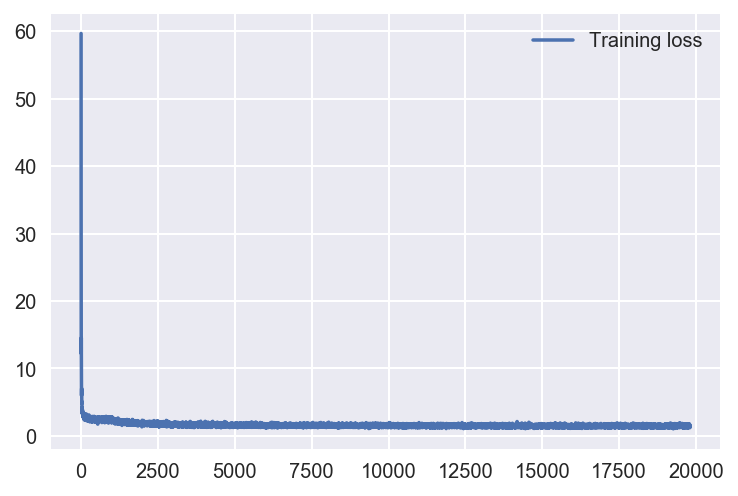

In [32]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

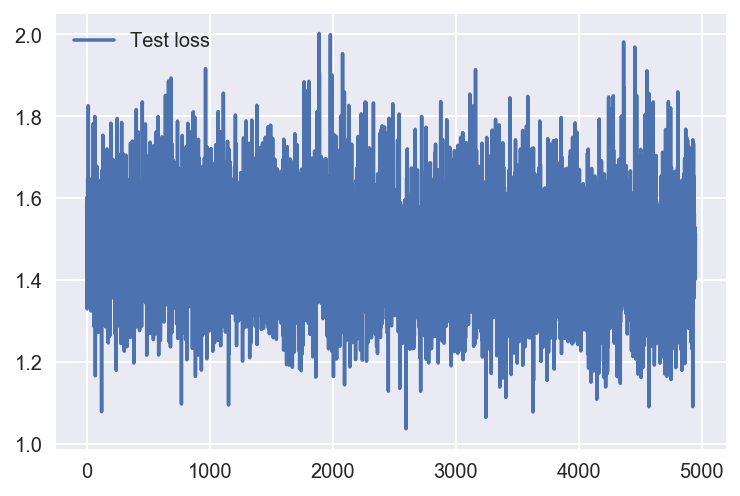

In [33]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [34]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    animation_id = loaded_graph.get_tensor_by_name("animation_id:0")
    animation_categories = loaded_graph.get_tensor_by_name("animation_categories:0")
    animation_type=loaded_graph.get_tensor_by_name("animation_type:0")
    animation_name = loaded_graph.get_tensor_by_name("animation_name:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
    # inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") #
    animation_combine_layer_flat = loaded_graph.get_tensor_by_name("animation_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, animation_id, animation_categories,animation_type,animation_name, targets, lr, dropout_keep_prob, inference, animation_combine_layer_flat, user_combine_layer_flat


In [35]:
animationid2idx = {val[1]:i for i, val in enumerate(animation_drop_o2.values)}
def rating_animation(user_id_val, animation_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, animation_id, animation_categories,animation_type,animation_name, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 82])
        categories[0] = animation_drop.values[animationid2idx[animation_id_val]][3]#这里要改
        
        types = np.zeros([1, 6])
        types[0] = animation_drop.values[animationid2idx[animation_id_val]][4]#这里要改
        
        name = np.zeros([1, sentences_size])
        name[0] = animation_drop.values[animationid2idx[animation_id_val]][2]#这里要改
    
        feed = {
              uid: np.reshape(user.values[user_id_val][1], [1, 1]),
              animation_id: np.reshape(animation_drop.values[animationid2idx[animation_id_val]][1], [1, 1]),
              animation_categories: categories,  #x.take(6,1)
              animation_type:types,
              animation_name: name,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [36]:
rating_animation(1,8074)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 7.31021214]], dtype=float32)]

In [37]:
loaded_graph = tf.Graph()  #
animation_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Get Tensors from loaded model
    uid, animation_id, animation_categories, animation_types,animation_name, targets, lr, dropout_keep_prob, _, animation_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph
    for item in animation_drop.values:
        categories = np.zeros([1, 82])
        categories[0] = item.take(3)
        
        types=np.zeros([1,6])
        types[0]=item.take(4)
        
        name = np.zeros([1, sentences_size])
        name[0] = item.take(2)
        feed = {
            animation_id: np.reshape(item.take(1), [1, 1]),
            animation_categories: categories,  #x.take(6,1)
            animation_types:types,
            animation_name: name,  #x.take(5,1)
            dropout_keep_prob: 1}
        animation_combine_layer_flat_val = sess.run([animation_combine_layer_flat], feed)  
        animation_matrics.append(animation_combine_layer_flat_val)
pickle.dump((np.array(animation_matrics).reshape(-1, 200)), open('animation_matrics.p', 'wb'))

INFO:tensorflow:Restoring parameters from ./save


In [38]:
import pickle
animation_matrics = pickle.load(open('animation_matrics.p', mode='rb'))

In [39]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, animation_id, animation_categories,animation_type, animation_name, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in user.values:

        feed = {
            uid: np.reshape(item.take(1), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))

INFO:tensorflow:Restoring parameters from ./save


In [40]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [41]:
def recommend_same_type_animation(animation_id_val, top_k):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        norm_animation_matrics = tf.sqrt(tf.reduce_sum(tf.square(animation_matrics), 1, keep_dims=True))
        normalized_animation_matrics = animation_matrics / norm_animation_matrics
  
        #推荐同类型的动漫
        probs_embeddings = (animation_matrics[animationid2idx[animation_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_animation_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的动漫是：{}".format(animation_drop_o[animationid2idx[animation_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(len(p), 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(animation_drop_o[val])
        
        return results

In [48]:
recommend_same_type_animation(1, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的动漫是：[22 1 'Cowboy Bebop' 'Action, Adventure, Comedy, Drama, Sci-Fi, Space' 'TV'
 '26' 8.82 486824]
以下是给您的推荐：
37
[37 31757 'Kizumonogatari II: Nekketsu-hen'
 'Action, Mystery, Supernatural, Vampire' 'Movie' '1' 8.73 34347]
38
[38 19 'Monster'
 'Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller' 'TV'
 '74' 8.72 247562]
22
[22 1 'Cowboy Bebop' 'Action, Adventure, Comedy, Drama, Sci-Fi, Space' 'TV'
 '26' 8.82 486824]
91
[91 13125 'Shinsekai yori' 'Drama, Horror, Mystery, Sci-Fi, Supernatural'
 'TV' '25' 8.53 288376]
29
[29 2001 'Tengen Toppa Gurren Lagann'
 'Action, Adventure, Comedy, Mecha, Sci-Fi' 'TV' '27' 8.78 562962]


{22, 29, 37, 38, 91}

In [43]:
def recommend_your_favorite_animation(user_id_val, top_k = 30):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(animation_matrics))
        sim = (probs_similarity.eval())
        

    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(len(p), 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(animation_drop_o[val])

        return results


In [49]:
recommend_your_favorite_animation(1, 30)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
8
[8 15335 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' 'Movie' '1'
 9.1 72534]
9
[9 15417 'Gintama&#039;: Enchousen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' 'TV' '13'
 9.11 81109]
50
[50 7785 'Yojouhan Shinwa Taikei' 'Mystery, Psychological, Romance' 'TV'
 '11' 8.65 122531]
20
[20 263 'Hajime no Ippo' 'Comedy, Drama, Shounen, Sports' 'TV' '75' 8.83
 157670]
29
[29 2001 'Tengen Toppa Gurren Lagann'
 'Action, Adventure, Comedy, Mecha, Sci-Fi' 'TV' '27' 8.78 562962]


{8, 9, 20, 29, 50}

In [45]:
def recommend_other_users(animation_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_animation_embeddings = (animation_matrics[animationid2idx[animation_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_animation_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的动漫是：{}".format(animation_drop_o[animationid2idx[animation_id_val]][2]))
        
        print("同样还喜欢看这个动漫的人是(编号)：{}".format(user.values[favorite_user_id-1][:,1]))

In [50]:
recommend_other_users(32281, 10)

INFO:tensorflow:Restoring parameters from ./save
您看的动漫是：Kimi no Na wa.
同样还喜欢看这个动漫的人是(编号)：[31004 53129 20906 58635 31500 40805 53073 47888 34318 64678]
